In [4]:
import pandas as pd
import networkx as nx
import re
import sys

nodes=pd.read_csv('data/nodes.csv')
edges=pd.read_csv('data/edges.csv')

float_re=re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')

def parse_position_string(pos_str):
    nums = float_re.findall(str(pos_str))
    return float(nums[0]), float(nums[1])

G=nx.Graph()

for _, row in nodes.iterrows():
    x, y= parse_position_string(row['pos'])
    G.add_node(row['index'], x=x, y=y)

for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'])

nx.write_gexf(G,'network.gexf')

In [6]:
nx.average_shortest_path_length(G)

18.989185424445708

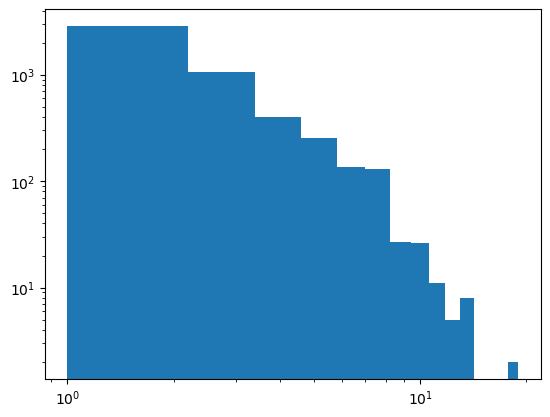

In [16]:
import matplotlib.pyplot as plt
degrees = [i for _, i in G.degree()]
plt.hist(degrees, bins = 15)
plt.xscale('log')
plt.yscale('log')

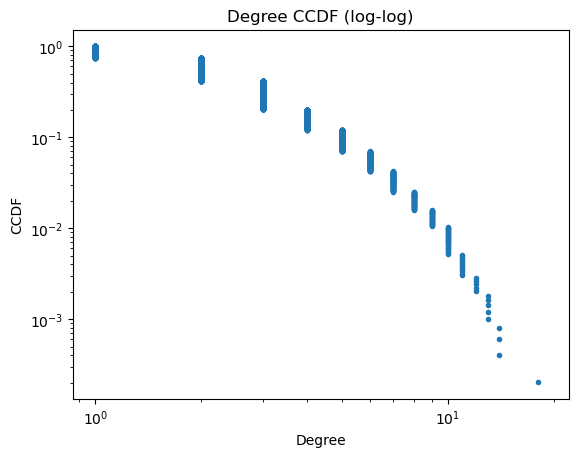

In [19]:
import numpy as np, matplotlib.pyplot as plt
degrees = [d for _, d in G.degree()]
data = np.array(degrees)
x = np.sort(data)
ccdf = 1 - np.arange(1, len(x)+1)/len(x)

plt.loglog(x, ccdf, marker='.', linestyle='none')
plt.xlabel("Degree")
plt.ylabel("CCDF")
plt.title("Degree CCDF (log-log)")
plt.show()

In [20]:
import powerlaw
fit = powerlaw.Fit(degrees, discrete=True)

for alt in ['exponential', 'lognormal', 'truncated_power_law']:
    R, p = fit.distribution_compare('power_law', alt, normalized_ratio=True)
    print(alt, "R:", R, "p:", p)

Calculating best minimal value for power law fit
c:\Users\karat\miniconda3\Lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Assuming nested distributions


exponential R: -1.7586784027434899 p: 0.07863214773161177
lognormal R: -6.758735755673953 p: 1.3920100208918788e-11
truncated_power_law R: -7.443360729259171 p: 0.0


Exponential (R = -1.76, p = 0.079): Interpretation: Negative R means exponential fits better than pure power law, but p > 0.05 is weak evidence. You can’t confidently claim exponential is superior; it’s not clearly random-like.

Lognormal (R = -6.76, p ≈ 1.39e-11): Interpretation: Strong, statistically significant preference for lognormal over pure power law. This suggests a heavy-tailed distribution with curvature on log–log plots (consistent with what you observed).

Truncated power law (R = -7.44, p = 0.0): Interpretation: Very strong evidence that a truncated power law (power law with an exponential cutoff) fits better than a pure power law. Since truncated power law nests the pure power law, this specifically indicates a heavy tail with a cutoff (e.g., physical/geographic constraints).

In [ ]:
import powerlaw
degrees = [d for _, d in G.degree()]
fit = powerlaw.Fit(degrees)
print("Alpha (exponent):", fit.power_law.alpha)
print("xmin:", fit.power_law.xmin)
R, p = fit.distribution_compare('power_law', 'exponential')
print("Comparison R:", R, "p-value:", p)

Calculating best minimal value for power law fit
c:\Users\karat\miniconda3\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


Alpha (exponent): 10.43584815827752
xmin: 10.0
Comparison R: 3.072977110353444 p-value: 0.011405961612904674


c:\Users\karat\miniconda3\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


Alpha ≈ 10.4: That’s very steep. Typical scale‑free networks have exponents between about 2 and 3. An exponent that high means the tail decays extremely quickly — so although the fitting routine technically found a power‑law, it’s not the kind of heavy‑tailed distribution usually associated with “scale‑free” networks.

xmin = 10: The fit only considers degrees ≥ 10. That means the apparent power‑law behavior is restricted to the higher‑degree nodes, not the whole network.

R = 3.07, p ≈ 0.011: Positive R and p < 0.05 means the power‑law fit is statistically better than exponential for the tail of the distribution.

👉 Conclusion: Statistically, the test prefers a power‑law over exponential for degrees ≥ 10, but the exponent is unusually large. That suggests the grid network is not strongly scale‑free — it’s sparse, with only a few moderately high‑degree nodes, and the tail drops off faster than in classic heavy‑tailed networks.